The aim of this code is to classify emotion categories. It consists of some steps. We will explain the procedure step by step:


#Installing Requirements


In [1]:
!pip install tensorflow
!pip install -U sentence_transformers
!pip install gensim==3.8.3
!pip install keras

     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 2.1MB 26.7MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
     |████████████████████████████████| 901kB 45.4MB/s 
     |████████████████████████████████| 3.3MB 48.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=a5c7a209c4c830b606720de6350981604a6e7394316a6e269c8380a35b1b30e7
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers
     |████████████████████████████████| 24.2MB 2.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


#Import Necessary Libraries


In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import gensim
from gensim.utils import tokenize
from gensim.models import FastText
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_non_alphanum
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity




# Set Constant Variables
In this part we set some variables, we want to consider TF-IDF in our feature vector, so we calculated TF-IDF. We want to train FastText from scratch so we consider from_scratch = True. Finally, the length of FastText in our scenarios is considered 300, so we assigned 300 to FT_VECTOR_SIZE.

In [3]:
#Config Variables 
tfidf_based =  True
from_scratch = True
FT_VECTOR_SIZE = 300


# Dataset Prepartion



## Downloading the dataset

First download the goemotion data from Internet.


In [4]:
!git init 
!git remote add -f origin https://github.com/google-research/google-research.git
!git config core.sparseCheckout true
!echo "goemotions/data/" >> .git/info/sparse-checkout
!git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 32520, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 32520 (delta 1), reused 8 (delta 1), pack-reused 32512
Receiving objects: 100% (32520/32520), 263.31 MiB | 32.20 MiB/s, done.
Resolving deltas: 100% (17478/17478), done.
From https://github.com/google-research/google-research
 * [new branch]        dependabot/pip/dql_grasping/pillow-8.1.1 -> origin/dependabot/pip/dql_grasping/pillow-8.1.1
 * [new branch]        dependabot/pip/dreg_estimators/tensorflow-2.4.0 -> origin/dependabot/pip/dreg_estimators/tensorflow-2.4.0
 * [new branch]        master     -> origin/master
From https://github.com/google-research/google-research
 * branch              master     -> FETCH_HEAD




# Data Preprocess

### Loading the list of emotion labels

In [5]:
f = open('/content/goemotions/data/emotions.txt')
lines  =f.readlines()
emotions = {}
for idx,label in enumerate(lines):
  emotions[idx] = label.strip()
emotions

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

##ِData Display

First, we read the "tsv" files contatining train, dev and test datasets.

In [9]:

dfTrain = pd.read_csv('/content/goemotions/data/train.tsv', sep = '\t', header=None, names = ['text' , 'label', 'rater'])
dfDev = pd.read_csv('/content/goemotions/data/dev.tsv', sep = '\t', header=None, names = ['text' , 'label', 'rater'])
dfTest = pd.read_csv('/content/goemotions/data/test.tsv', sep = '\t', header=None, names = ['text' , 'label', 'rater'])
data = pd.concat([dfTrain,dfTest, dfDev], ignore_index=True)


data.text = data.text.apply(lambda s: s.lower() )


##One-Hot Encoding
As the labels are emotion categories, we converted this nominal type of labels to numerical using one-hot encoding


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
x = mlb.fit_transform( [tuple(int(x) for x in i.split(',')) for i in data.label.to_list()])
data['new_label'] = list(x)
len(data.new_label[0])


28

## Display Distribution of Data
Using "matplotlib" we draw plot shows the distribution of number of labels amond dataset. Each column shows the frequency of label for a specific number of labels in Train Set.

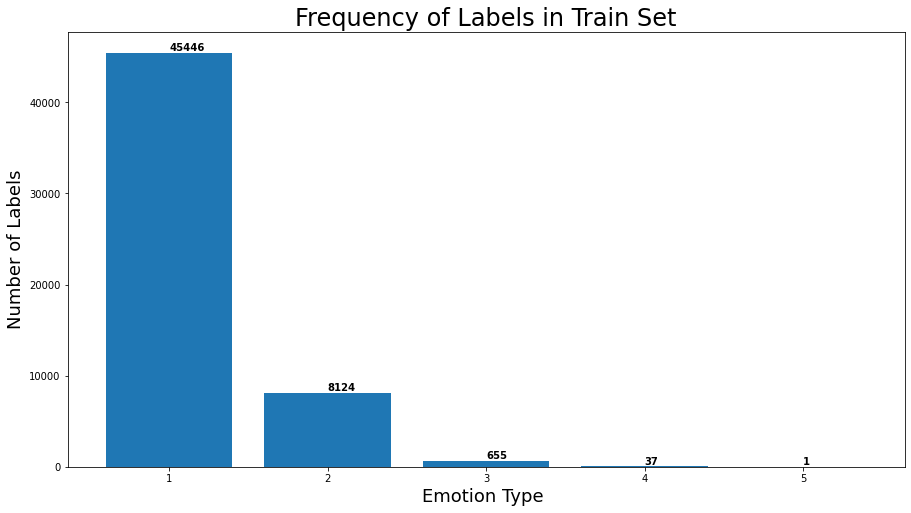

In [11]:
import matplotlib.pyplot as plt
#Number of labels
a = np.array(data.new_label.to_list()).sum(axis = 1)
(unique, counts) = np.unique(a, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies
labelcount = [1, 2, 3, 4, 5]
plt.figure(figsize=(15,8))
plt.bar(labelcount, frequencies[:, 1], align='center')
plt.title("Frequency of Labels in Train Set", fontsize=24)
plt.ylabel('Number of Labels', fontsize=18)
plt.xlabel('Emotion Type ', fontsize=18)
for i, v in enumerate(frequencies[:, 1]):
    plt.text(i+1, i+v+200, str(v), color='black', fontweight='bold')
# plt.xticks(emotionsInt, LABELS, rotation='vertical')
plt.show()

Now, we want to draw a plot to show the distribution of data based on emotion categories. In this figure, each column shows the number of samples belonged to each emotion category.

In [12]:
hist_test = data[43410:(5427 +43410)]['new_label'].sum(axis = 0)[:-1]
hist_train = data[:43410]['new_label'].sum(axis = 0)[:-1]
hist_dev = data[(5427 +43410):]['new_label'].sum(axis = 0)[:-1]

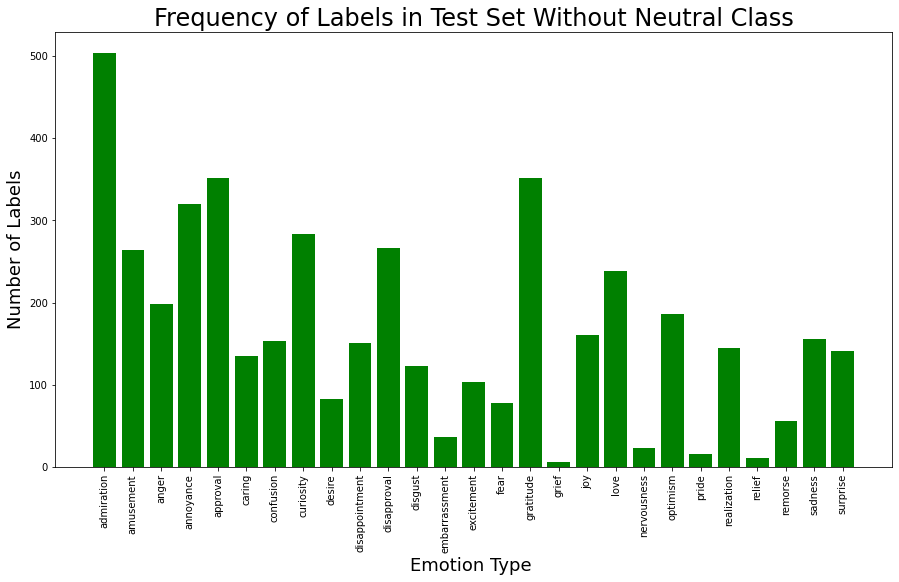

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

#with neutrual
# plt.figure(figsize=(15,8))
# plt.grid(zorder=0)
# emotionsInt = [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 , 20, 21, 22,23, 24, 25, 26, 27, 28]
# LABELS = list(emotions.values())
# plt.bar(emotionsInt, data[:43410]['new_label'].sum(axis = 0), align='center')
# plt.title("Frequency of Labels in Train Set", fontsize=24)
# plt.ylabel('Number of Labels', fontsize=18)
# plt.xlabel('Emotion Type ', fontsize=18)
# plt.xticks(emotionsInt, LABELS, rotation='vertical')
# plt.show()

#without neutrual
# plt.figure(figsize=(15,8))
# emotionsInt = [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 , 20, 21, 22,23, 24, 25, 26, 27]
# LABELS = (list(emotions.values()))[:-1]
# plt.bar(emotionsInt, (data[:43410]['new_label'].sum(axis = 0))[:-1], align='center', color = ['green'])
# plt.title("Frequency of Labels in Train Set Without Neutral Class", fontsize=24)
# plt.ylabel('Number of Labels', fontsize=18)
# plt.xlabel('Emotion Type ', fontsize=18)
# plt.xticks(emotionsInt, LABELS, rotation='vertical')
# plt.show()


# plt.bar(emotionsInt, data[43410:(5427 +43410)]['new_label'].sum(axis = 0), align='center')
# plt.title("Frequency of Labels in Test Set", fontsize=24)
# plt.ylabel('Number of Labels', fontsize=18)
# plt.xlabel('Emotion Type ', fontsize=18)
# plt.xticks(emotionsInt, LABELS, rotation='vertical')
# plt.show()


#without neutrual
plt.figure(figsize=(15,8))
emotionsInt = [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 , 20, 21, 22,23, 24, 25, 26, 27]
LABELS = (list(emotions.values()))[:-1]
plt.bar(emotionsInt, (data[43410:(5427 +43410)]['new_label'].sum(axis = 0))[:-1], align='center', color = 'green')
# plt.bar(emotionsInt,[ hist_train, hist_test], align='center', color='green')
plt.title("Frequency of Labels in Test Set Without Neutral Class", fontsize=24)
plt.ylabel('Number of Labels', fontsize=18)
plt.xlabel('Emotion Type ', fontsize=18)
plt.xticks(emotionsInt, LABELS, rotation='vertical')
plt.show()

# Model Building



## Feature Selection



### Bert Feature
First, we downloaded a pretrained Bert model.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
modelBert = SentenceTransformer('monologg/bert-base-cased-goemotions-original')
modelBert.get_sentence_features

Exception when trying to download http://sbert.net/models/monologg/bert-base-cased-goemotions-original.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/monologg/bert-base-cased-goemotions-original.zip not found. Try to create it from scratch
Try to create Transformer Model monologg/bert-base-cased-goemotions-original with mean pooling


<bound method SentenceTransformer.get_sentence_features of SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): L

In [16]:
def bert_embedding(sentences):
   
  sentence_embeddings = modelBert.encode(sentences)
  return sentence_embeddings

In [ ]:
bert_features = bert_embedding(data.text.to_list())

###Training FastText Model and TFIDF model with GoEmotion Dataset

In [ ]:
def fasttext_model_train(data, from_scratch):
  # Preprocessing like stopword removal @TODO
  ge_sentences = [ list(tokenize(s)) for s in data['text'].to_list()]
  if from_scratch:
    model = FastText(bucket= 1000000, window=3, min_count=1, size=300)
    model.build_vocab(sentences=ge_sentences)
    model.train(sentences=ge_sentences, total_examples=len(ge_sentences), epochs=10)
  else:
    model = FastText.load_fasttext_format('content/cc.en.300')
    model.build_vocab(ge_sentences, update=True)
    model.train(sentences=ge_sentences, total_examples = len(sent), epochs=5)
  return model
  #now the model has been trained, there are two ways to get the sentence vectors, 
  # first, simple averaging over the word vectors, like numpy.mean(...)
  # second, using the tfidf to applying a weighted average method,
  # There is an option using the original fastext library in python where the sentence vecotr is available but can be formolated here simply by adding two more functions 



In [ ]:
#TFIDF
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
def gensim_tfidf_model_train(data):
   data = [ list(tokenize(s)) for s in data['text'].to_list()]
   print(len(data))
   dct = Dictionary(data)
   print(data[0:10])
   corpus = [dct.doc2bow(line) for line in data] # convert corpus to BoW format
   model = TfidfModel(corpus)
   return dct, model

In [ ]:
#TF-IDF Using SK_learn # needs a list of lists for words and docs along with a fasttext 'model'
def tfidf_model_train(data):
  tf_idf_vect = TfidfVectorizer(stop_words=None)
  tf_idf_vect.fit(data)
  final_tf_idf = tf_idf_vect.transform(data)
  tfidf_feat = tf_idf_vect.get_feature_names()
  return tfidf_feat, final_tf_idf



In [ ]:
fastText_model = fasttext_model_train(data, from_scratch)  # training fastext
dictionary, tfidf_model = tfidf_model_train(data["text"].to_list())


In [ ]:
tfidf_model.getrow(2)

<1x29512 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [ ]:
# Sum( tfidf[word] * wvector) / sum(tfidf(words))
#@TODO maybe later develop the BM25 alg. 
def get_sentence_vector(row, sent_tokens, dictionary, tfidf_model, ft_model, tfidf_based= False):
  if not tfidf_based:
    word_vectors = []
    for  token in sent_tokens:
        w_vector = ft_model.wv[token]
        word_vectors.append(w_vector)
    return np.mean(word_vectors, axis=0)
  else:
    vec_sum = np.zeros(FT_VECTOR_SIZE)
    weight= 0;
    for token in sent_tokens:
      # print(token)
      try :
        index = dictionary.index(token)
      except:
        index = -1
      if index != -1:
        w_vector = ft_model.wv[token]
        # print("Vecotr ",w_vector)
        tfidf_score =  tfidf_model[row, index ]
        # print(tfidf_score)
        vec_sum +=  (tfidf_score * w_vector )
        weight += tfidf_score
    return vec_sum / weight

In [ ]:
from tqdm import tqdm
# Fasttext word embedding 
def fasttext_embedding(model, data, dictionary, tfidf_model):
  sentence_vectors = []
   
  row = 0;
  for sentence in tqdm(data,position=0, leave=True):
    sent_tokens =  tokenize(sentence.lower())
    sentence_vectors.append(get_sentence_vector(row,sent_tokens, dictionary, tfidf_model, model, tfidf_based))
    row +=1
    # print(sentence_vectors)
  return sentence_vectors


In [ ]:
fatf_feature = fasttext_embedding(fastText_model, data.text.to_list(), dictionary, tfidf_model)


 93%|█████████▎| 50272/54263 [05:15<00:28, 141.75it/s]

##Calculate FABEEC feature 
In this part we calculated FABEEC feature and added it beside to Bert and FastText + TFIDF as columns to GoEmotion dataframes.

In [ ]:

fabeec = []
for i in range(len(bert_features)):
  fabeec.append( bert_features[i].tolist() + fatf_feature[i].tolist())
data['fabeec'] = fabeec

bertValues = []
for i in range(len(bert_features)):
  bertValues.append(bert_features[i].tolist())
data['bert'] = bertValues


data['fastfatf'] = fatf_feature


In [ ]:
# Adding embedded features to each data set for Train, Test, and Dev sets. 
start = 0
end  =  dfTrain.shape[0] 

dfTrain['fabeec'] = data.fabeec[start:end]
dfTrain['new_label'] = data.new_label[start:end]

start= dfTrain.shape[0]
end=  start + dfTest.shape[0]
dfTest ['fabeec'] = data.fabeec[start:end].values
dfTest['new_label'] = data.new_label[start:end].values

start= end
dfDev ['fabeec'] = data.fabeec[start:].values
dfDev['new_label'] = data.new_label[start:].values

In [ ]:
np.array(dfTrain.new_label.to_list())

## Remove NAN features from dataset

In [ ]:
#Drop the rows with None elements 

def get_nan_ids(df):
  j = 0
  to_drop = []
  for i in df.fabeec.to_list():
    if np.any(np.isnan(i)):
        to_drop.append(j)
    j+=1
  return to_drop

#remove nan for Train set
to_drop = get_nan_ids(dfTrain)
dfTrain = dfTrain.drop(to_drop)
print("Number of removed items in trainin set that contains Nan : {}, the removed inexes {}".format(len(to_drop), to_drop ))

#remove nan for dev test
to_drop = get_nan_ids(dfDev)
dfDev = dfDev.drop(to_drop)
print("Number of removed items in Dev set that contains Nan  : {}, the removed inexes {}".format(len(to_drop), to_drop ))

#remove nan for test data
to_drop = get_nan_ids(dfTest)
dfTest = dfTest.drop(to_drop)
print("Number of removed items in Test set that contains Nan  : {}, the removed inexes {}".format(len(to_drop), to_drop ))


Number of removed items in trainin set that contains Nan : 11, the removed inexes [2318, 9418, 13499, 16490, 18628, 27961, 32409, 37960, 40589, 41148, 42011]
Number of removed items in Dev set that contains Nan  : 0, the removed inexes []
Number of removed items in Test set that contains Nan  : 2, the removed inexes [2083, 4026]


#Pipeline Classifiers
## constructing pipeline for all classifiers

In [ ]:
isBert = True
isFastText = False
isFabeec = False

y_Train = np.array(dfTrain.new_label.to_list())

if isBert:
  X_train = np.array(dfTrain.bert.to_list() + dfDev.bert.to_list())
  X_test = np.array(dfTest.bert.to_list())
elif isFastText:
  X_train = np.array(dfTrain.fastfatf.to_list() + dfDev.fastfatf.to_list())
  X_test = np.array(dfTest.fastfatf.to_list())
else 
  X_train = np.array(dfTrain.fabeec.to_list() + dfDev.fabeec.to_list())
  X_test = np.array(dfTest.fabeec.to_list())



In [ ]:
from sklearn import tree
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.cross_validation import cross_val_score
# from sklearn.linear_model import SGDRegressor,BayesianRidge,ARDRegression, PassiveAggressiveRegressor, TheilSenRegressor,LinearRegression
# import xgboost
classifiers = [
    KNeighborsClassifier(),
#     SGDRegressor(),
# #      ,
#        BayesianRidge(),
# #      LassoLars(),
# #      ARDRegression()
#       PassiveAggressiveRegressor(),
#      TheilSenRegressor(),
#     LinearRegression(),
#     xgboost.XGBRegressor(early_stopping_rounds=10),
#     xgboost.XGBRegressor(colsample_bytree= 0.8, gamma= 0, min_child_weight= 10, learning_rate=0.07, max_depth= 3, 
                        #  n_estimators= 250, reg_alpha= 1e-05, reg_lambda= 0.01, subsample= 0.95, early_stopping_rounds=10
# )
]
# # y_pred = model.predict(test_X)
# # y_pred = target_scaler.inverse_transform(y_pred)
# def mpe (pred, real):
#     y_test, y_pred = np.array(real), np.array(pred)
#     return  np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# mpe_res = []

precision = []
recall []
f1



for item in classifiers:
    print(item)
    clf = item
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
y_pred

#     results["micro_precision"], results["micro_recall"], results[
#       "micro_f1"], _  = precision_recall_fscore_support(y_test, y_pred, average='macro')
#       results["micro_precision"], results["micro_recall"], results[
#       "micro_f1"], _  = precision_recall_fscore_support(y_test, y_pred, average='micro')
#       results["micro_precision"], results["micro_recall"], results[
#       "micro_f1"], _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')


#   pred_ind = preds_mat.copy()
#   pred_ind[pred_ind > threshold] = 1
#   pred_ind[pred_ind <= threshold] = 0

  
#   for i in range(len(preds)):
#     true_labels = [int(idx) for idx in true.loc[i, "labels"].split(",")]
#     for j in range(num_emotions):
#       preds_mat[i, j] = preds.loc[i, idx2emotion[j]]
#       true_mat[i, j] = 1 if j in true_labels else 0

#     mpe_res.append(mpe(  clf.predict(X_test), np.ravel(y_test)))
# print(mpe_res)

In [ ]:
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from pprint import pprint



dfTrain.reset_index()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(np.array(dfTrain.fabeec.to_list()), np.array(dfTrain.new_label.to_list()))

ModuleNotFoundError: ignored

In [ ]:
clf.get_params()

NameError: ignored

In [ ]:
res = clf.predict(dfTrain.fabeec.to_list())

In [ ]:
from sklearn.metrics import f1_score

f1_score(dfTrain.new_label.to_list(), res, average='macro')

0.9989913286013007

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(100,200,10), 'min_samples_split':range(5,56,10), 'max_features':['sqrt','log2']}
clf_1 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf_1.fit(X=np.array(dfTrain.fabeec.to_list()), y=np.array(dfTrain.new_label.to_list()))
tree_model = clf_1.best_estimator_
print (clf_1.best_score_, clf_1.best_params_) 
dump(multilabel_classifier,'dt.joblib')
!cp 'svm.joblib' '/content/drive/MyDrive/dt.joblib'


0.7102234882334232 {'max_depth': 170, 'max_features': 'sqrt', 'min_samples_split': 25}


LiearSVM classifer for multi-lable problem 

In [ ]:
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

X_train = np.array(dfTrain.fabeec.to_list())
y_train = np.array(dfTrain.new_label.to_list())
# Create the SVM
svm = LinearSVC(random_state=42)
# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(X_train, y_train)


X_test = np.array(dfTest.fabeec.to_list())
# Get predictions for test data
y_test_pred = multilabel_classifier.predict(X_test)




In [ ]:
predcited_res = multilabel_classifier.predict(X_train)
f1_score(dfTrain.new_label.to_list(), predcited_res, average='macro')

from joblib import dump, load
dump(multilabel_classifier,'svm.joblib')
!cp 'svm.joblib' '/content/drive/MyDrive/svm.joblib'
print (f1_score)

<function f1_score at 0x7fd47815b680>


In [ ]:
import pickle
s = pickle.dumps(clf_1, 'decision_tree.joblib')

pickle.dumps(multilabel_classifier, 'svm.joblib')

!cp 'decision_tree.joblib' '/content/drive/MyDrive/decision_tree.joblib'
!cp 'svm.joblib' '/content/drive/MyDrive/svm.joblib'

TypeError: ignored

# KNN For multi label classifier


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(5, 6)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
X_train = np.array(dfTrain.fabeec.to_list())
y_train = np.array(dfTrain.new_label.to_list())
knn_gscv.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
knn_gscv

In [ ]:
from joblib import dump


knn_model = knn_gscv.best_estimator_
print (knn_gscv.best_score_, knn_gscv.best_params_) 
dump(knn_gscv,'knn.joblib')
!cp 'knn.joblib' '/content/drive/MyDrive/knn.joblib'

In [ ]:
X_test = np.array(dfTest.fabeec.to_list())
y_test = np.array(dfTest.new_label.to_list())
knn_gscv.predict(X_test)
knn_gscv.score(X_test, y_test)

# Random Forest for MultiLabel Classifier

In [ ]:
X_train = np.array(dfTrain.fabeec.to_list())
y_train = np.array(dfTrain.new_label.to_list())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [5],
    'n_estimators': [50, 100, 300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, verbose = 2, n_jobs = -1)
grid_search.fit(X_train[1:1000], y_train[1:1000])


rf_model = grid_search.best_estimator_
print (grid_search.best_score_, grid_search.best_params_) 
dump(grid_search,'rf.joblib')
!cp 'rf.joblib' '/content/drive/MyDrive/rf.joblib'



Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.0min finished


0.6569000264481762 {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
X_test = np.array(dfTest.fabeec.to_list())
y_test = np.array(dfTest.new_label.to_list())
grid_search.predict(X_test)
grid_search.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.28012521348046004

In [ ]:
from joblib import dump
rf_model = grid_search.best_estimator_
print (rf_mode..best_score_, rf.best_params_) 
dump(rf,'rf.joblib')
!cp 'rf.joblib' '/content/drive/MyDrive/rf.joblib'

# CNN for Multilabel Text Classification

In [ ]:
X_train.shape
y_train.shape
X_test.shape

NameError: ignored

In [ ]:
X_test = np.array(dfTest.fabeec.to_list())
y_test = np.array(dfTest.new_label.to_list())

X_train = np.array(dfTrain.fabeec.to_list() + dfDev.fabeec.to_list())
y_train = np.array(dfTrain.new_label.to_list() + dfDev.new_label.to_list())

# X_train1 = np.array(dfTrain.fabeec.to_list()).reshape(X_train.shape[0], 1, X_train.shape[1])
X_train1 = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train1= y_train.reshape(y_train.shape[0], y_train.shape[1])

X_test1 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test1= y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
X_train = []
X_test =[]

In [ ]:
# np.savetxt('X_train.csv', X_train, delimiter=',')
# np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')


In [ ]:
!cp /content/drive/MyDrive/fabeec/X_test.csv X_test.csv 
!cp /content/drive/MyDrive/fabeec/X_train.csv X_train.csv 

In [ ]:
from numpy import genfromtxt
X_train = genfromtxt('X_train.csv', delimiter=',')
X_test = genfromtxt('X_test.csv', delimiter=',')
y_train = genfromtxt('y_train.csv', delimiter=',')
y_test = genfromtxt('y_test.csv', delimiter=',')

In [ ]:
X_train1 = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train1= y_train.reshape(y_train.shape[0], y_train.shape[1])

X_test1 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test1= y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, MaxPooling1D, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import models
from keras.regularizers import l2   

num_classes = 28

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (1068, 1)))

model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))


model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01) ))
model.add(Dense(28, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=40),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = model.fit(X_train1, y_train1,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

y_pred = model.predict(X_test1)


# new_model = models.load_model('model-conv1d.h5')
# loss, acc = new_model.evaluate(X_test1, y_test1, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(new_model.predict(X_test1))

Epoch 1/200
1374/1374 [==============================] - 10s 7ms/step - loss: 0.1791 - categorical_accuracy: 0.7701 - val_loss: 0.1242 - val_categorical_accuracy: 0.5345
Epoch 2/200
1374/1374 [==============================] - 9s 7ms/step - loss: 0.0474 - categorical_accuracy: 0.8614 - val_loss: 0.1226 - val_categorical_accuracy: 0.5398
Epoch 3/200
1374/1374 [==============================] - 9s 7ms/step - loss: 0.0457 - categorical_accuracy: 0.8626 - val_loss: 0.1274 - val_categorical_accuracy: 0.5359
Epoch 4/200
1374/1374 [==============================] - 9s 7ms/step - loss: 0.0463 - categorical_accuracy: 0.8631 - val_loss: 0.1228 - val_categorical_accuracy: 0.5357
Epoch 5/200
1374/1374 [==============================] - 9s 6ms/step - loss: 0.0450 - categorical_accuracy: 0.8609 - val_loss: 0.1228 - val_categorical_accuracy: 0.5390
Epoch 6/200
1374/1374 [==============================] - 9s 7ms/step - loss: 0.0442 - categorical_accuracy: 0.8644 - val_loss: 0.1264 - val_categorical_ac

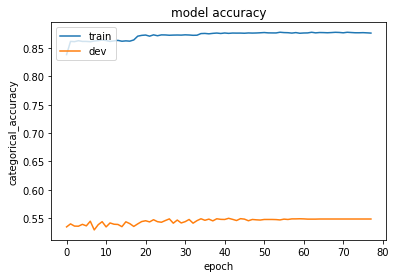

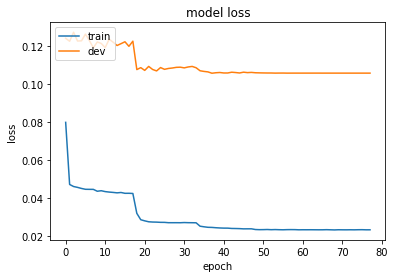

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(13, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# epochs = 5
# batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def Calculate_metric(y_test, y_pred):
    y_test[y_test > .3] = 1
    y_test[y_test <= .3] = 0

    results = {}
    results["macro_precision"], results["macro_recall"], results["macro_f1"], _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro')
    results["micro_precision"], results["micro_recall"], results["micro_f1"], _ = precision_recall_fscore_support(
        y_test, y_pred, average='micro')
    results["weighted_precision"], results["weighted_recall"], results[
        "weighted_f1"], _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    #       num_emotions = len(emotions)

    #   idx2emotion = {i: e for i, e in enumerate(emotions)}

    #   preds_mat = np.zeros((len(preds), num_emotions))
    #   true_mat = np.zeros((len(preds), num_emotions))
    #   for i in range(len(preds)):
    #     true_labels = [int(idx) for idx in true.loc[i, "labels"].split(",")]
    #     for j in range(num_emotions):
    #       preds_mat[i, j] = preds.loc[i, idx2emotion[j]]
    #       true_mat[i, j] = 1 if j in true_labels else 0

    #   threshold = 0.3 # FLAGS.threshold
    #   pred_ind = preds_mat.copy()
    #   pred_ind[pred_ind > threshold] = 1
    #   pred_ind[pred_ind <= threshold] = 0
    #   results = {}
    #   results["accuracy"] = accuracy_score(true_mat, pred_ind)
    #   results["macro_precision"], results["macro_recall"], results[
    #       "macro_f1"], _ = precision_recall_fscore_support(
    #           true_mat, pred_ind, average="macro")
    #   results["micro_precision"], results["micro_recall"], results[
    #       "micro_f1"], _ = precision_recall_fscore_support(
    #           true_mat, pred_ind, average="micro")
    #   results["weighted_precision"], results["weighted_recall"], results[
    #       "weighted_f1"], _ = precision_recall_fscore_support(
    #           true_mat, pred_ind, average="weighted")
    #   for i in range(num_emotions):
    #     emotion = idx2emotion[i]
    #     emotion_true = true_mat[:, i]
    #     emotion_pred = pred_ind[:, i]
    #     results[emotion + "_accuracy"] = accuracy_score(emotion_true, emotion_pred)
    #     results[emotion + "_precision"], results[emotion + "_recall"], results[
    #         emotion + "_f1"], _ = precision_recall_fscore_support(
    #             emotion_true, emotion_pred, average="binary")
    return results







temp = Calculate_metric(y_test1, y_pred)
print(temp)







NameError: ignored

In [ ]:

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_cnn = y_train.reshape(y_train.shape[0], y_train.shape[1])

X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_cnn = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)
y_pred = model.predict(X_test_cnn)

y_pred[y_pred > .3] = 1
y_pred[y_pred <= .3] = 0
print(y_pred)
print(y_test)
results = Calculate_metric(y_test, y_pred)
print(results)

ValueError: ignored

In [ ]:
def fabeec_embedding(data):
  fasttext_embedding = fasttext_embedding(data)
  bert_embedding = bert_embedding(data)
  data['embedding'] = fasttext_embedding + bert_embedding
  return data

## Tokenization

In [ ]:
df["token_size"] = df["text"].apply(lambda x: len(x.split(' ')))

In [ ]:

#sentences = ['This framework generates embeddings for each input sentence',
 #   'Sentences are passed as a list of string.', 
 #   'The quick brown fox jumps over the lazy dog.']


In [ ]:
without_nutral = list(emotions.values())[:-1]
without_nutral = list(emotions.values())

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = emotionsInt
men_means = hist_train
women_means = hist_dev

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15,10)
rects1 = ax.bar(x , men_means, width, label='Train Set')
# rects2 = ax.bar(x , women_means, width, label='Test Set', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Frequecy of samples in each class (Test Set)')
ax.set_xticks(range(len(emotions)))
ax.set_xticklabels(emotions)
ax.legend()
for i , v in enumerate(hist_dev):
  ax.text(i-.25,  v + 5, str(v), color='black', fontweight='bold')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.xticks(range(len(without_nutral)), without_nutral, rotation=90)
# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
plt.show()

NameError: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, MaxPooling1D, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import models
from keras.regularizers import l2 


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape = (1068, 1)))

model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(28, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]


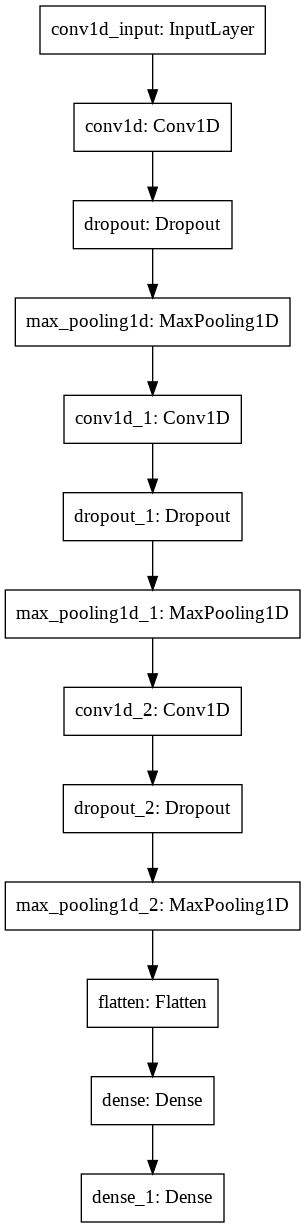

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')